Found 8859 images belonging to 2 classes.
Found 2214 images belonging to 2 classes.
Epoch 1/15


C:\Users\abhishik chebrolu\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


276/276 ━━━━━━━━━━━━━━━━━━━━ 806s 3s/step - accuracy: 0.4409 - loss: 0.0600 - val_accuracy: 0.5210 - val_loss: 0.0434
Epoch 2/15
  1/276 ━━━━━━━━━━━━━━━━━━━━ 1:01:08 13s/step - accuracy: 0.4521 - loss: 0.0406

c:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


276/276 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.4521 - loss: 0.0406 - val_accuracy: 0.4013 - val_loss: 0.0406
Epoch 3/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 970s 3s/step - accuracy: 0.4879 - loss: 0.0396 - val_accuracy: 0.5994 - val_loss: 0.0404
Epoch 4/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5169 - loss: 0.0339 - val_accuracy: 0.5471 - val_loss: 0.0338
Epoch 5/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 688s 2s/step - accuracy: 0.5198 - loss: 0.0356 - val_accuracy: 0.5800 - val_loss: 0.0362
Epoch 6/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5399 - loss: 0.0336 - val_accuracy: 0.6600 - val_loss: 0.0377
Epoch 7/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 631s 2s/step - accuracy: 0.5423 - loss: 0.0329 - val_accuracy: 0.5769 - val_loss: 0.0357
Epoch 8/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4824 - loss: 0.0320 - val_accuracy: 0.6168 - val_loss: 0.0388
Epoch 9/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 672s 2s/step - accuracy: 0.5488 - loss: 0.0312 - val_accuracy: 0.6146 -

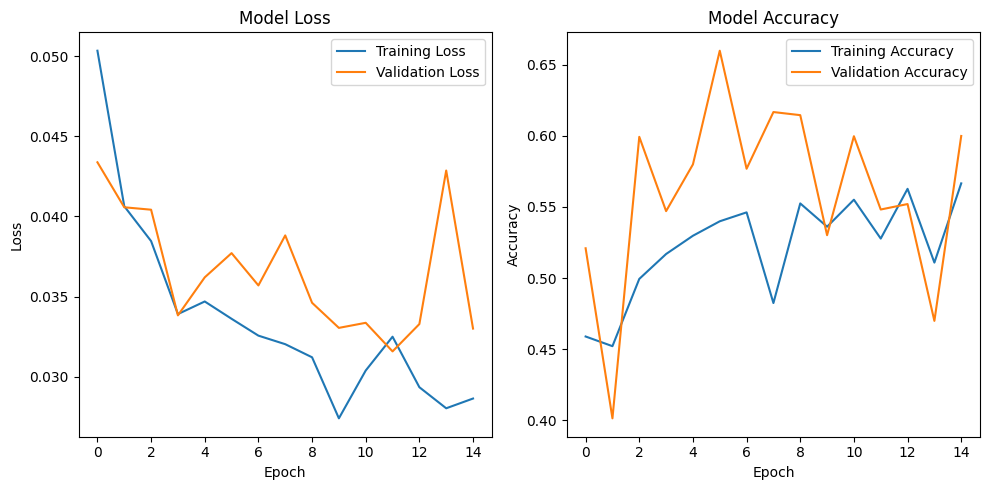

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Create Transfer Learning Autoencoder (VGG16 as Encoder)
def create_transfer_learning_autoencoder(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the encoder (VGG16) layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Decoder (ensure correct output size: 224x224x3)
    x = base_model.output  # The output from VGG16 will be (7, 7, 512)

    # Decoder starts here: reverse the pooling/downsampling
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # From (7, 7, 512) to (14, 14, 512)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # From (14, 14, 256) to (28, 28, 256)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # From (28, 28, 128) to (56, 56, 128)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # From (56, 56, 64) to (112, 112, 64)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # From (112, 112, 32) to (224, 224, 32)

    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Final output shape (224, 224, 3)

    # Create autoencoder model
    autoencoder = Model(base_model.input, decoded)
    return autoencoder

# Compile the model
def compile_autoencoder(autoencoder):
    autoencoder.compile(optimizer=Adam(learning_rate=0.0001), 
                        loss='mean_squared_error',
                        metrics=['accuracy'])

# Test the model and calculate performance metrics
def test_autoencoder(autoencoder, test_generator):
    # Predict the reconstruction on the test set
    reconstructions = autoencoder.predict(test_generator)
    
    # Compute reconstruction error (Mean Squared Error) for each sample
    errors = np.mean(np.abs(reconstructions - test_generator[0][0]), axis=(1, 2, 3))
    
    # Use a threshold to classify anomalies (assuming high reconstruction error as anomaly)
    threshold = 0.02  # You can tune this value based on the dataset
    anomalies = errors > threshold
    
    # Test labels (for binary classification task)
    true_labels = np.array([1 if 'violence' in file else 0 for file in test_generator.filenames])

    # Calculate metrics
    accuracy = accuracy_score(true_labels, anomalies)
    precision = precision_score(true_labels, anomalies)
    recall = recall_score(true_labels, anomalies)
    f1 = f1_score(true_labels, anomalies)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    
    return accuracy, precision, recall, f1

# Main function to execute workflow
def main():
    dataset_path = r'C:\Users\abhishik chebrolu\Downloads\AINN pro\archive\new_violence'  # Path to your dataset with violence and non-violence frames
    input_shape = (224, 224, 3)
    
    # Create and compile the autoencoder
    autoencoder = create_transfer_learning_autoencoder(input_shape)
    compile_autoencoder(autoencoder)
    
    # Use ImageDataGenerator for data loading and augmentation
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        validation_split=0.2  # Automatically split 20% for validation
    )
    
    batch_size = 32
    
    # Train and validation data generators
    train_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='input',  # For autoencoder, input and target are the same
        subset='training'
    )
    
    val_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='input',  # For autoencoder, input and target are the same
        subset='validation'
    )
    
    # Test data generator (no augmentation)
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,  # For autoencoder, no labels required in the generator
        shuffle=False
    )
    
    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the autoencoder
    history = autoencoder.fit(
        train_generator,
        validation_data=val_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_steps=val_generator.samples // batch_size,
        epochs=15,
        callbacks=[early_stopping]
    )
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Test the autoencoder and calculate performance metrics
    print("Testing the autoencoder...")
    test_autoencoder(autoencoder, test_generator)

if __name__ == "__main__":
    main()
